In [44]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import prepare_token_data, prepare_price_data
import api.address_constants as ac
from datetime import datetime

sns.set(style='whitegrid')

# Data paths
eETH_underlying_path = 'data/eETH/EETH-USD.csv'
etherfi_tvl_path = 'data/eETH/etherfi_tvl.csv'
etherfi_eETH_yt_jun_path = 'data/eETH/etherfi_eETH_Jun_yt_ohlcv_data.csv'
etherfi_eETH_pt_jun_path = 'data/eETH/etherfi_eETH_Jun_pt_ohlcv_data.csv'
etherfi_eETH_yt_sep_path = 'data/eETH/etherfi_eETH_Sep_yt_ohlcv_data.csv'
etherfi_eETH_pt_sep_path = 'data/eETH/etherfi_eETH_Sep_pt_ohlcv_data.csv'
etherfi_eETH_yt_dec_path = 'data/eETH/etherfi_eETH_Dec_yt_ohlcv_data.csv'
etherfi_eETH_pt_dec_path = 'data/eETH/etherfi_eETH_Dec_pt_ohlcv_data.csv'
zircuit_tvl_path = 'data/eETH/zircuit_tvl.csv'
zircuit_eETH_yt_jun_path = 'data/eETH/zircuit_eETH_Jun_yt_ohlcv_data.csv'
zircuit_eETH_pt_jun_path = 'data/eETH/zircuit_eETH_Jun_pt_ohlcv_data.csv'

ezETH_underlying_path = 'data/ezETH/EZETH-USD.csv'
renzo_tvl_path = 'data/ezETH/renzo_tvl.csv'
ezETH_yt_sep_path = 'data/ezETH/ezETH_Sep_yt_ohlcv_data.csv'
ezETH_pt_sep_path = 'data/ezETH/ezETH_Sep_pt_ohlcv_data.csv'
ezETH_yt_dec_path = 'data/ezETH/ezETH_Dec_yt_ohlcv_data.csv'
ezETH_pt_dec_path = 'data/ezETH/ezETH_Dec_pt_ohlcv_data.csv'

pufETH_underlying_path = 'data/pufETH/PUFETH-USD.csv'
puffer_tvl_path = 'data/pufETH/puffer_tvl.csv'
pufETH_yt_jun_path = 'data/pufETH/pufETH_Jun_yt_ohlcv_data.csv'
pufETH_pt_jun_path = 'data/pufETH/pufETH_Jun_pt_ohlcv_data.csv'
pufETH_yt_sep_path = 'data/pufETH/pufETH_Sep_yt_ohlcv_data.csv'
pufETH_pt_sep_path = 'data/pufETH/pufETH_Sep_pt_ohlcv_data.csv'

uniETH_underlying_path = 'data/uniETH/UNIETH-USD.csv'
bedrock_tvl_path = 'data/uniETH/bedrock_tvl.csv'
uniETH_yt_jun_path = 'data/uniETH/uniETH_Jun_yt_ohlcv_data.csv'
uniETH_pt_jun_path = 'data/uniETH/uniETH_Jun_pt_ohlcv_data.csv'
uniETH_yt_sep_path = 'data/uniETH/uniETH_Sep_yt_ohlcv_data.csv'
uniETH_pt_sep_path = 'data/uniETH/uniETH_Sep_pt_ohlcv_data.csv'

rsETH_underlying_path = 'data/rsETH/RSETH-USD.csv'
kelp_tvl_path = 'data/rsETH/kelp_tvl.csv'
rsETH_yt_jun_path = 'data/rsETH/rsETH_Jun_yt_ohlcv_data.csv'
rsETH_pt_jun_path = 'data/rsETH/rsETH_Jun_pt_ohlcv_data.csv'
rsETH_yt_sep_path = 'data/rsETH/rsETH_Sep_yt_ohlcv_data.csv'
rsETH_pt_sep_path = 'data/rsETH/rsETH_Sep_pt_ohlcv_data.csv'

# Load the data
etherfi_eETH_jun_df = prepare_token_data(eETH_underlying_path, etherfi_eETH_yt_jun_path, etherfi_eETH_pt_jun_path, ac.etherfi_eETH_Jun_start_date, ac.expiry_date_jun, etherfi_tvl_path)
etherfi_eETH_sep_df = prepare_token_data(eETH_underlying_path, etherfi_eETH_yt_sep_path, etherfi_eETH_pt_sep_path, ac.etherfi_eETH_Sep_start_date, ac.expiry_date_sep, etherfi_tvl_path)
etherfi_eETH_dec_df = prepare_token_data(eETH_underlying_path, etherfi_eETH_yt_dec_path, etherfi_eETH_pt_dec_path, ac.etherfi_eETH_Dec_start_date, ac.expiry_date_dec, etherfi_tvl_path)
zircuit_eETH_jun_df = prepare_token_data(eETH_underlying_path, zircuit_eETH_yt_jun_path, zircuit_eETH_pt_jun_path, ac.zircuit_eETH_Jun_start_date, ac.expiry_date_jun, zircuit_tvl_path)

ezETH_sep_df = prepare_token_data(ezETH_underlying_path, ezETH_yt_sep_path, ezETH_pt_sep_path, ac.ezETH_Sep_start_date, ac.expiry_date_sep, renzo_tvl_path)
ezETH_dec_df = prepare_token_data(ezETH_underlying_path, ezETH_yt_dec_path, ezETH_pt_dec_path, ac.ezETH_Dec_start_date, ac.expiry_date_dec, renzo_tvl_path)

pufETH_jun_df = prepare_token_data(pufETH_underlying_path, pufETH_yt_jun_path, pufETH_pt_jun_path, ac.pufETH_Jun_start_date, ac.expiry_date_jun, puffer_tvl_path)
pufETH_sep_df = prepare_token_data(pufETH_underlying_path, pufETH_yt_sep_path, pufETH_pt_sep_path, ac.pufETH_Sep_start_date, ac.expiry_date_sep, puffer_tvl_path)

uniETH_jun_df = prepare_token_data(uniETH_underlying_path, uniETH_yt_jun_path, uniETH_pt_jun_path, ac.uniETH_Jun_start_date, ac.expiry_date_jun, bedrock_tvl_path)
uniETH_sep_df = prepare_token_data(uniETH_underlying_path, uniETH_yt_sep_path, uniETH_pt_sep_path, ac.uniETH_Sep_start_date, ac.expiry_date_sep, bedrock_tvl_path)

rsETH_jun_df = prepare_token_data(rsETH_underlying_path, rsETH_yt_jun_path, rsETH_pt_jun_path, ac.rsETH_Jun_start_date, ac.expiry_date_jun, kelp_tvl_path)
rsETH_sep_df = prepare_token_data(rsETH_underlying_path, rsETH_yt_sep_path, rsETH_pt_sep_path, ac.rsETH_Sep_start_date, ac.expiry_date_sep, kelp_tvl_path)

tokens = {
    'etherfi_eETH': {'Jun': etherfi_eETH_jun_df, 'Sep': etherfi_eETH_sep_df, 'Dec': etherfi_eETH_dec_df},
    'zircuit_eETH': {'Jun': zircuit_eETH_jun_df},
    'ezETH': {'Sep': ezETH_sep_df, 'Dec': ezETH_dec_df},
    'pufETH': {'Jun': pufETH_jun_df, 'Sep': pufETH_sep_df},
    'uniETH': {'Jun': uniETH_jun_df, 'Sep': uniETH_sep_df},
    'rsETH': {'Jun': rsETH_jun_df, 'Sep': rsETH_sep_df}
}

# Flatten the dictionary and prepare DataFrames for concatenation
dfs = []
for token_name, maturities in tokens.items():
    for maturity, df in maturities.items():
        # Ensure the date is the DataFrame index if not already
        if 'date' in df.columns:
            df.set_index('date', inplace=True)

        # Rename columns to include token and maturity information for uniqueness
        df.columns = [f"{token_name}_{maturity}_{col}" for col in df.columns]
        dfs.append(df)

# Concatenate all DataFrames on the date index
combined_df = pd.concat(dfs, axis=1)
combined_df.sort_index(inplace=True)

etherfi_eETH_jun_df = prepare_token_data(eETH_underlying_path, etherfi_eETH_yt_jun_path, etherfi_eETH_pt_jun_path, ac.etherfi_eETH_Jun_start_date, ac.expiry_date_jun, etherfi_tvl_path)
etherfi_eETH_sep_df = prepare_token_data(eETH_underlying_path, etherfi_eETH_yt_sep_path, etherfi_eETH_pt_sep_path, ac.etherfi_eETH_Sep_start_date, ac.expiry_date_sep, etherfi_tvl_path)
etherfi_eETH_dec_df = prepare_token_data(eETH_underlying_path, etherfi_eETH_yt_dec_path, etherfi_eETH_pt_dec_path, ac.etherfi_eETH_Dec_start_date, ac.expiry_date_dec, etherfi_tvl_path)
zircuit_eETH_jun_df = prepare_token_data(eETH_underlying_path, zircuit_eETH_yt_jun_path, zircuit_eETH_pt_jun_path, ac.zircuit_eETH_Jun_start_date, ac.expiry_date_jun, zircuit_tvl_path)

ezETH_sep_df = prepare_token_data(ezETH_underlying_path, ezETH_yt_sep_path, ezETH_pt_sep_path, ac.ezETH_Sep_start_date, ac.expiry_date_sep, renzo_tvl_path)
ezETH_dec_df = prepare_token_data(ezETH_underlying_path, ezETH_yt_dec_path, ezETH_pt_dec_path, ac.ezETH_Dec_start_date, ac.expiry_date_dec, renzo_tvl_path)

pufETH_jun_df = prepare_token_data(pufETH_underlying_path, pufETH_yt_jun_path, pufETH_pt_jun_path, ac.pufETH_Jun_start_date, ac.expiry_date_jun, puffer_tvl_path)
pufETH_sep_df = prepare_token_data(pufETH_underlying_path, pufETH_yt_sep_path, pufETH_pt_sep_path, ac.pufETH_Sep_start_date, ac.expiry_date_sep, puffer_tvl_path)

uniETH_jun_df = prepare_token_data(uniETH_underlying_path, uniETH_yt_jun_path, uniETH_pt_jun_path, ac.uniETH_Jun_start_date, ac.expiry_date_jun, bedrock_tvl_path)
uniETH_sep_df = prepare_token_data(uniETH_underlying_path, uniETH_yt_sep_path, uniETH_pt_sep_path, ac.uniETH_Sep_start_date, ac.expiry_date_sep, bedrock_tvl_path)

rsETH_jun_df = prepare_token_data(rsETH_underlying_path, rsETH_yt_jun_path, rsETH_pt_jun_path, ac.rsETH_Jun_start_date, ac.expiry_date_jun, kelp_tvl_path)
rsETH_sep_df = prepare_token_data(rsETH_underlying_path, rsETH_yt_sep_path, rsETH_pt_sep_path, ac.rsETH_Sep_start_date, ac.expiry_date_sep, kelp_tvl_path)

In [45]:
from abc import ABC, abstractmethod

class Asset:
    def __init__(self):
        self.position = 0
        self.current_price = 0
        self.unrealized_gain = 0
        self.realized_gain = 0

    def update_price(self, new_price):
        # Only update unrealized gains if there is an existing position
        if self.position != 0:
            price_diff = new_price - self.current_price
            self.unrealized_gain += self.position * price_diff
        self.current_price = new_price

    def execute_trade(self, delta_position):
        # Executing trade changes the position but does not affect gains
        self.position += delta_position

    def get_total_gain(self):
        return self.unrealized_gain + self.realized_gain

    def get_roi(self):
        if self.total_investment == 0:
            return float('inf')  # Avoid division by zero
        return (self.get_total_gain() / self.total_investment) * 100  # ROI as a percentage

class YieldToken(Asset):
    def update_daily_gain(self, daily_yield_rate, fee_rate=0.0003):
        # Apply daily gain based on the current position and price
        self.unrealized_gain += (1 - fee_rate) * self.position * daily_yield_rate * self.current_price

class PrincipalToken(Asset):
    def __init__(self):
        super().__init__()

    def liquidate(self, liquidation_price):
        self.realized_gain += max(self.position * (liquidation_price - self.current_price), 0)
        self.position = 0

class Strategy(ABC):
    @abstractmethod
    def trade(self, prices_df, current_index, underlying_pos, pt_pos, yt_pos):
        return (0, 0, 0)

def apply_strategy_to_all(strategy):
    return {
    'etherfi_jun': {'data': etherfi_eETH_jun_df, 'strategy': InvariantArbitrage()},
    'etherfi_sep': {'data': etherfi_eETH_sep_df, 'strategy': InvariantArbitrage()},
    'etherfi_dec': {'data': etherfi_eETH_dec_df, 'strategy': InvariantArbitrage()},
    'zircuit_jun': {'data': zircuit_eETH_jun_df, 'strategy': InvariantArbitrage()},
    'ezETH_sep': {'data': ezETH_sep_df, 'strategy': InvariantArbitrage()},
    'ezETH_dec': {'data': ezETH_dec_df, 'strategy': InvariantArbitrage()},
    'pufETH_jun': {'data': pufETH_jun_df, 'strategy': InvariantArbitrage()},
    'pufETH_sep': {'data': pufETH_sep_df, 'strategy': InvariantArbitrage()},
    'uniETH_jun': {'data': uniETH_jun_df, 'strategy': InvariantArbitrage()},
    'uniETH_sep': {'data': uniETH_sep_df, 'strategy': InvariantArbitrage()},
    'rsETH_jun': {'data': rsETH_jun_df, 'strategy': InvariantArbitrage()},
    'rsETH_sep': {'data': rsETH_sep_df, 'strategy': InvariantArbitrage()}
}

In [46]:
class PendleBacktest:
    def __init__(self, assets_strategies):
        self.assets = {
            name: {
                'data': asset['data'],
                'tokens': {
                    'underlying': Asset(),
                    'pt': PrincipalToken(),
                    'yt': YieldToken()
                },
                'strategy': asset['strategy']
            } for name, asset in assets_strategies.items()
        }
        self._prep_data()

    def _prep_data(self):
        for asset in self.assets.values():
            df = asset['data']
            df['cumulative_profit'] = 0

    def trade(self):
        overall_cumulative_profit = pd.Series(dtype=float)
        for name, asset in self.assets.items():
            df = asset['data']
            tokens = asset['tokens']
            strategy = asset['strategy']
            cumulative_profit = 0

            for index, current_prices in df.iterrows():
                # Update prices first, then trade
                tokens['underlying'].update_price(current_prices['underlying_open'])
                tokens['pt'].update_price(current_prices['pt_open'])
                tokens['yt'].update_price(current_prices['yt_open'])

                # Execute trades based on the strategy
                deltas = strategy.trade(df, index, tokens['underlying'].position, tokens['pt'].position, tokens['yt'].position)

                # Minting and Burning Arbitrage
                try:
                    if deltas[3] == True: # Make PT + YT - underlying profit
                        tokens['pt'].realized_gain += 0.009 * current_prices['pt_open']
                        tokens['yt'].realized_gain += 0.009 * current_prices['yt_open']
                        tokens['underlying'].realized_gain -= 0.01 * current_prices['underlying_open']
                    elif deltas[4] == True: # Make underlying - PT - YT profit
                        tokens['pt'].realized_gain -= 0.01 * current_prices['pt_open']
                        tokens['yt'].realized_gain -= 0.01 * current_prices['yt_open']
                        tokens['underlying'].realized_gain -= 0.09 * current_prices['underlying_open']
                except:
                    # Execute trades without affecting profit directly
                    tokens['underlying'].execute_trade(deltas[0])
                    tokens['pt'].execute_trade(deltas[1])
                    tokens['yt'].execute_trade(deltas[2])

                # Update daily yield for yield token
                if tokens['yt'].position != 0:
                    daily_yield_rate = ((1 + df.at[index, 'implied_apy']) ** (1/365) - 1)
                    tokens['yt'].update_daily_gain(daily_yield_rate)

                if df.loc[index, 'days_to_expiry'] == 1:
                    tokens['pt'].liquidate(current_prices['underlying_open'])

                # Aggregate profit updates
                cumulative_profit = sum([token.get_total_gain() for token in tokens.values()])
                df.at[index, 'cumulative_profit'] = cumulative_profit

            if overall_cumulative_profit.empty:
                overall_cumulative_profit = df['cumulative_profit'].copy()
            else:
                overall_cumulative_profit += df['cumulative_profit']

        return overall_cumulative_profit

    def calculate_max_drawdown_percentage(self, cumulative_profit):
        # Calculate the running maximum
        running_max = cumulative_profit.expanding().max()
        # Calculate the drawdown as a percentage
        drawdown = (cumulative_profit - running_max) / running_max
        # Find the minimum drawdown, i.e., the maximum negative value
        max_drawdown_percentage = drawdown.min() * 100  # Convert to percentage
        return max_drawdown_percentage

    def plot_profit(self, isHedged=False):
        cumulative_profit = self.trade()
        cumulative_profit = cumulative_profit.dropna()

        # Calculate profit
        print("Profit: {:.2f}".format(cumulative_profit[-1]))

        # Calculate maximum drawdown in percentage
        max_drawdown_percentage = self.calculate_max_drawdown_percentage(cumulative_profit)
        print("Max Drawdown: {:.2f}%".format(max_drawdown_percentage))

        # Calculate Sharpe ratio
        returns = np.log(cumulative_profit + 1) - np.log(cumulative_profit.shift(1) + 1)
        returns_cleaned = returns.replace([np.inf, -np.inf], np.nan).dropna()
        if returns_cleaned.std() != 0:
            sharpe_ratio = (returns_cleaned.mean() / returns_cleaned.std()) * np.sqrt(365)
        else:
            sharpe_ratio = float('nan')
        print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))

        # Calculate Sortino ratio
        sortino_ratio = (returns_cleaned.mean() / returns_cleaned[returns_cleaned < 0].std()) * np.sqrt(365)
        print("Sortino Ratio: {:.2f}".format(sortino_ratio))

        # Plot cumulative profit
        fig, ax = plt.subplots(figsize=(12, 6))
        cumulative_profit.plot(ax=ax)
        ax.set_title('Cumulative Profit Over Time' + (' (ETH)' if isHedged else ' (USD)'))
        ax.set_ylabel('Profit')
        ax.set_xlabel('Date')
        plt.show()

In [47]:
class PendleHedgedBacktest(PendleBacktest):
    def trade(self):
        overall_cumulative_profit = pd.Series(dtype=float)
        for name, asset in self.assets.items():
            df = asset['data']
            tokens = asset['tokens']
            strategy = asset['strategy']
            cumulative_profit = 0

            for index, current_prices in df.iterrows():
                # Update prices first, then trade
                tokens['pt'].update_price(current_prices['pt_open_eth'])
                tokens['yt'].update_price(current_prices['yt_open_eth'])

                deltas = strategy.trade(df, index, tokens['underlying'].position, tokens['pt'].position, tokens['yt'].position)

                # Minting and Burning Arbitrage
                try:
                    # assume 0.01 eth is used for each time to minimize the impact of slippage
                    if deltas[3] == True: # Make PT + YT - underlying profit
                        tokens['pt'].realized_gain += 0.009 * current_prices['pt_open_eth']
                        tokens['yt'].realized_gain += 0.009 * current_prices['yt_open_eth']
                        tokens['underlying'].realized_gain - 0.01
                    elif deltas[4] == True: # Make underlying - PT - YT profit
                        tokens['pt'].realized_gain -= 0.01 * current_prices['pt_open_eth']
                        tokens['yt'].realized_gain -= 0.01 * current_prices['yt_open_eth']
                        tokens['underlying'].realized_gain += 0.009
                except:
                    # Execute trades without affecting profit directly
                    # Strategies can either return (_, pt, yt) or (pt, yt). This makes non-hedged strategies compatible.
                    try:
                        tokens['yt'].execute_trade(deltas[2])
                        tokens['pt'].execute_trade(deltas[1])
                    except:
                        tokens['yt'].execute_trade(deltas[1])
                        tokens['pt'].execute_trade(deltas[0])

                # Update daily yield for yield token
                if tokens['yt'].position != 0:
                    daily_yield_rate = ((1 + df.at[index, 'implied_apy']) ** (1/365) - 1)
                    tokens['yt'].update_daily_gain(daily_yield_rate)

                # Liquidate principal token if it is the last day
                if df.loc[index, 'days_to_expiry'] == 1:
                    tokens['pt'].liquidate(1)

                # Aggregate profit updates
                cumulative_profit = sum([token.get_total_gain() for token in tokens.values()])
                df.at[index, 'cumulative_profit'] = cumulative_profit

            if overall_cumulative_profit.empty:
                overall_cumulative_profit = df['cumulative_profit'].copy()
            else:
                overall_cumulative_profit += df['cumulative_profit']

        return overall_cumulative_profit

    def plot_profit(self):
        super().plot_profit(isHedged=True)

### Getting Long YT of long maturity and short the short maturity ( you can duration adjust them) for similar underlyings

In [48]:

# class DurationLongStrategy(Strategy):
#     def trade(self, prices_df, current_index):
#         current_row = prices_df.loc[current_index]
#         days_to_expiry = current_row['days_to_expiry']
#         return (0, 0, 1)

# class DurationShortStrategy(Strategy):
#     def trade(self, prices_df, current_index):
#         current_row = prices_df.loc[current_index]
#         days_to_expiry = current_row['days_to_expiry']
#         return (0, 0, -1)

# assets_strategies = {
#     'etherfi_jun': {'data': etherfi_eETH_jun_df, 'strategy': DurationLongStrategy()},
#     # 'etherfi_dec': {'data': etherfi_eETH_dec_df, 'strategy': DurationShortStrategy()}
# }

# backtest = PendleBacktest(assets_strategies)
# backtest.plot_profit()

### Buying High Fixed Yields

Profit: 63136.64
Max Drawdown: -80.38%
Sharpe Ratio: -1.50
Sortino Ratio: -2.18


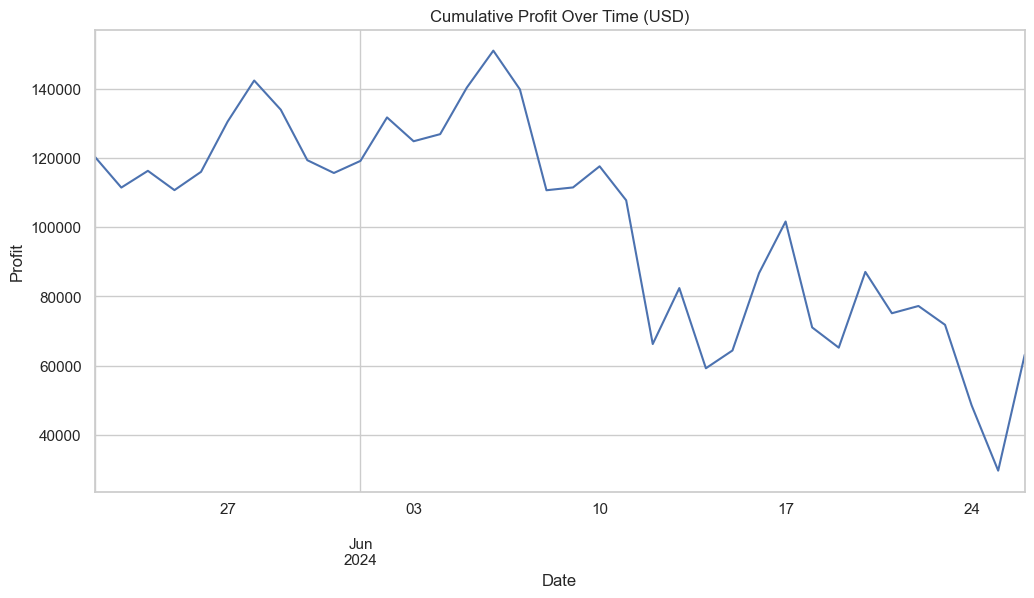

In [49]:
class HighFixedYield(Strategy):
    def trade(self, prices_df, current_index, underlying_pos, pt_pos, yt_pos):
        current_row = prices_df.loc[current_index]
        if current_row['fixed_yield'] > 0.4:
            return (0, 1, 0)
        elif current_row['fixed_yield'] < 0.05 and pt_pos > 1:
            return (0, -1, 0)
        return (0, 0, 0)

assets_strategies = {
    'etherfi_jun': {'data': etherfi_eETH_jun_df, 'strategy': HighFixedYield()},
    'etherfi_sep': {'data': etherfi_eETH_sep_df, 'strategy': HighFixedYield()},
    'etherfi_dec': {'data': etherfi_eETH_dec_df, 'strategy': HighFixedYield()},
    'zircuit_jun': {'data': zircuit_eETH_jun_df, 'strategy': HighFixedYield()},
    'ezETH_sep': {'data': ezETH_sep_df, 'strategy': HighFixedYield()},
    'ezETH_dec': {'data': ezETH_dec_df, 'strategy': HighFixedYield()},
    'pufETH_jun': {'data': pufETH_jun_df, 'strategy': HighFixedYield()},
    'pufETH_sep': {'data': pufETH_sep_df, 'strategy': HighFixedYield()},
    'uniETH_jun': {'data': uniETH_jun_df, 'strategy': HighFixedYield()},
    'uniETH_sep': {'data': uniETH_sep_df, 'strategy': HighFixedYield()},
    'rsETH_jun': {'data': rsETH_jun_df, 'strategy': HighFixedYield()},
    'rsETH_sep': {'data': rsETH_sep_df, 'strategy': HighFixedYield()},
}

backtest = PendleBacktest(assets_strategies)
backtest.plot_profit()

### PT/YT arbitrage

Profit: 8.13
Max Drawdown: 0.00%
Sharpe Ratio: 122.97
Sortino Ratio: nan


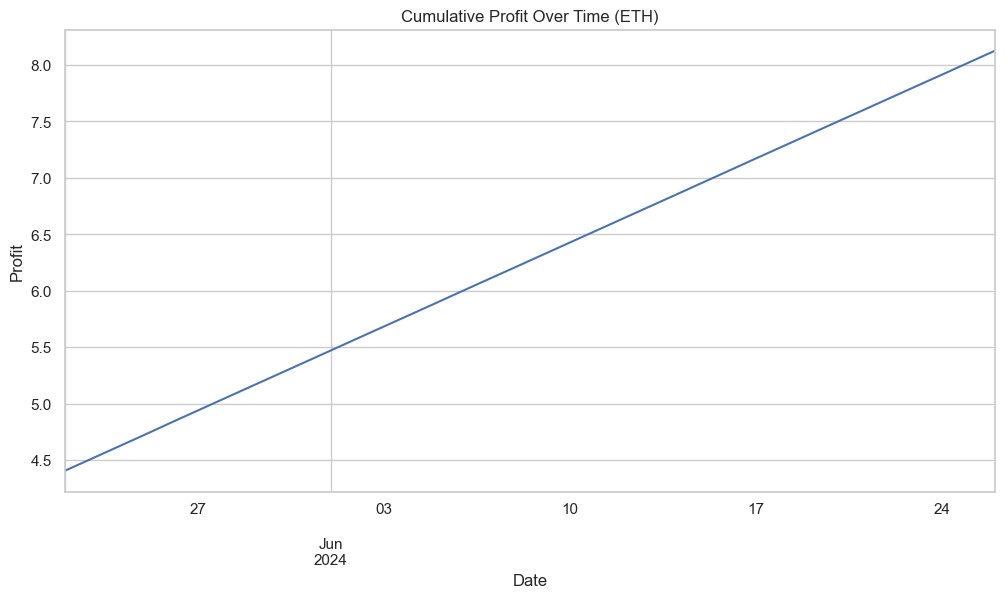

In [50]:
class InvariantArbitrage(Strategy):
    def trade(self, prices_df, current_index, underlying_pos, pt_pos, yt_pos):
        current_row = prices_df.loc[current_index]
        if current_row['pt_open'] + current_row['yt_open'] > current_row['underlying_open']:
            return (0, 0, 0, True, False) # Make YT + PT - Underlying profit
        elif current_row['pt_open'] + current_row['yt_open'] < current_row['underlying_open']:
            return (0, 0, 0, True, False) # Make Underlying - YT - PT profit
        return (0, 0, 0)

assets_strategies = {
    'etherfi_jun': {'data': etherfi_eETH_jun_df, 'strategy': InvariantArbitrage()},
    'etherfi_sep': {'data': etherfi_eETH_sep_df, 'strategy': InvariantArbitrage()},
    'etherfi_dec': {'data': etherfi_eETH_dec_df, 'strategy': InvariantArbitrage()},
    'zircuit_jun': {'data': zircuit_eETH_jun_df, 'strategy': InvariantArbitrage()},
    'ezETH_sep': {'data': ezETH_sep_df, 'strategy': InvariantArbitrage()},
    'ezETH_dec': {'data': ezETH_dec_df, 'strategy': InvariantArbitrage()},
    'pufETH_jun': {'data': pufETH_jun_df, 'strategy': InvariantArbitrage()},
    'pufETH_sep': {'data': pufETH_sep_df, 'strategy': InvariantArbitrage()},
    'uniETH_jun': {'data': uniETH_jun_df, 'strategy': InvariantArbitrage()},
    'uniETH_sep': {'data': uniETH_sep_df, 'strategy': InvariantArbitrage()},
    'rsETH_jun': {'data': rsETH_jun_df, 'strategy': InvariantArbitrage()},
    'rsETH_sep': {'data': rsETH_sep_df, 'strategy': InvariantArbitrage()}
}

# backtest = PendleBacktest(apply_strategy_to_all(InvariantArbitrage()))
# backtest = PendleHedgedBacktest(apply_strategy_to_all(InvariantArbitrage()))
backtest = PendleHedgedBacktest(assets_strategies)
backtest.plot_profit()